# Flood Adaptation: Minimal Model

This python script outlines a basic Agent-Based Model (ABM) developed using the Mesa framework, designed as a simplified representation of household adaptation to flood events in a social network context. The model serves as a template for understanding the fundamental mechanics of flood adapdtation with a given social network.

This directory is structured as follows:
 - A Mesa Agent class `Households` is defined in `agents.py`
 - A Mesa Agent class `Government` is defined in `agents.py` (this agent currently does not perform any action)
 - A Mesa Model class `AdaptationModel` is defined in `model.py`
 - This notebook `demo.ipynb` provides a demonstration of the model and its visualization.

Each household agent in the model represents a household with attributes and behaviors that determine its response to flood events. The flood depth attribute assigned to each household is currently random for demonstration purposes. The decision by each household to adapt is also arbitrary. In a more comprehensive model, this could be replaced with more sophisticated decision-making algorithms.

The current implementation includes several simplifications and arbitrary choices, such as random flood depths and basic adaptation logic based on random thresholds. These aspects are designed for clarity and ease of understanding and should be replaced with realistic and sound choices.

You are encouraged to modify, expand, and customize the model. This might include integrating real-world data, implementing more complex decision-making processes for agents, or exploring different network topologies and their effects on social dynamics.

The visualisation provided is basic. Additional aspects can be added for visualization and more in-depth analysis.

_This notebook was tested on 2023-11-13 with Mesa version 2.1.4 on Python 3.12.0._

Model will run for 80 ticks where each tick is 1/4 of a year.

# Running the model and visualizing the model domain and social network over time

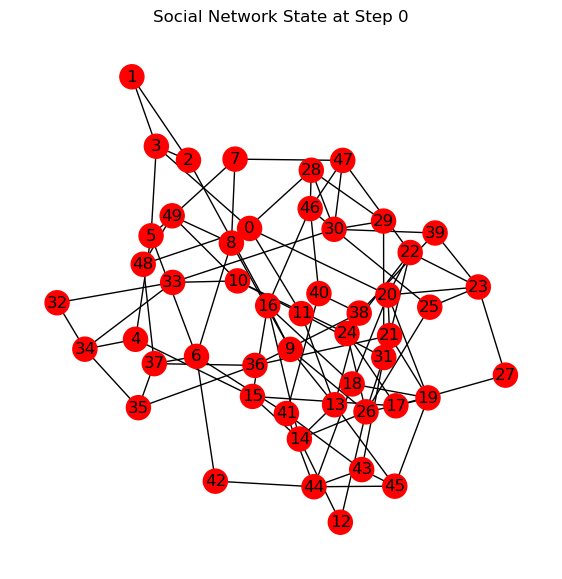

0.20625867173062362
0.48627378624881273
0.5698653611389537
0.615871806235185


<Figure size 1000x600 with 0 Axes>

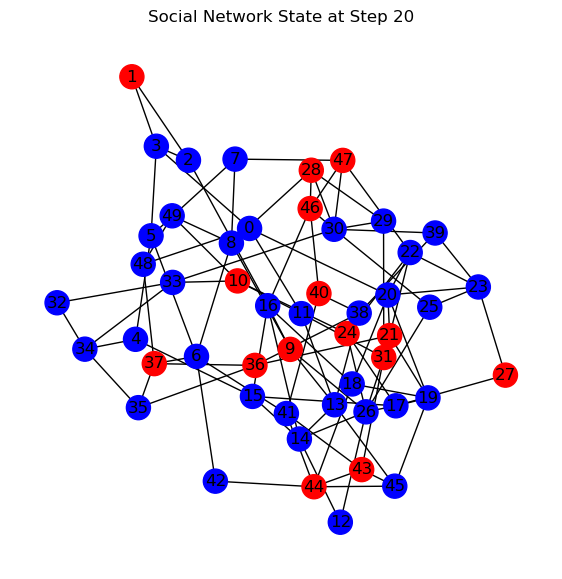

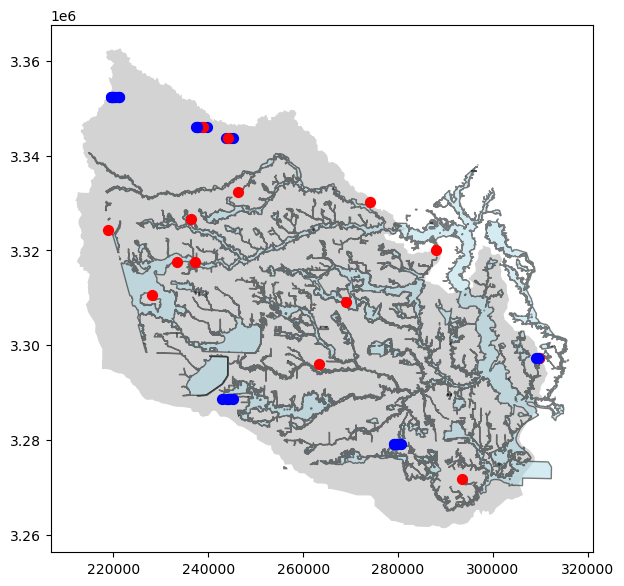

In [1]:
from model import AdaptationModel
import matplotlib.pyplot as plt
import networkx as nx
from functions import map_domain_gdf, floodplain_gdf

# Initialize the Adaptation Model with 50 household agents.
model = AdaptationModel(number_of_households=50, number_of_zones=2, flood_map_choice="harvey", network="watts_strogatz", adaptation_threshold=0.2) # flood_map_choice can be "harvey", "100yr", or "500yr"
# Calculate positions of nodes for the network plot.
# The spring_layout function positions nodes using a force-directed algorithm,
# which helps visualize the structure of the social network.
pos = nx.spring_layout(model.G)

# Define a function to plot agents on the network.
# This function takes a matplotlib axes object and the model as inputs.
def plot_network(ax, model):
    # Clear the current axes.
    ax.clear()
    # Determine the color of each node (agent) based on their adaptation status
    household_agents = []
    for agent in model.schedule.agents:
        if agent.type == 'household':
            household_agents.append(agent)
        
    colors = ['blue' if agent.is_adapted else 'red' for agent in household_agents]

    # Draw the network with node colors and labels.
    nx.draw(model.G, pos, node_color=colors, with_labels=True, ax=ax)
    # Set the title of the plot with the current step number.
    ax.set_title(f"Social Network State at Step {model.schedule.steps}", fontsize=12)

# Plot the initial state of the social network.
fig, ax = plt.subplots(figsize=(7, 7))
plot_network(ax, model)
plt.show()

# Run the model for 20 steps and generate plots every 5 steps.
for step in range(model.number_of_steps):
    model.step()

    # Every 5 steps, generate and display plots for both the spatial distribution and network.
    # Note the first step is step 0, so the plots will be generated at steps 4, 9, 14, and 19, which are the 5th, 10th, 15th, and 20th steps.
    if step  == 19:
        # Plot for the spatial map showing agent locations and adaptation status.
        plt.figure(figsize=(10, 6))
        #model.plot_model_domain_with_agents()

        # Plot for the social network showing connections and adaptation statuses.
        fig, ax = plt.subplots(figsize=(7, 7))
        plot_network(ax, model)
        plt.show()

# Plot the model domain
fig, ax = plt.subplots(figsize=(7, 7))
map_domain_gdf.plot(ax=ax, color='lightgrey')
#Plot the floodplain
floodplain_gdf.plot(ax=ax, color='lightblue', edgecolor='k', alpha=0.5)
for agent in model.schedule.agents:
    if agent.type == "household" and agent.is_adapted == False:
        #get position on the map
        ax.scatter(agent.location.x, agent.location.y, color='red', s=50)  # Bigger, hollow circle
    elif agent.type == 'household':
        ax.scatter(agent.location.x, agent.location.y, color='blue', s=50)  # Smaller, filled circle

In [16]:

agent_data = model.datacollector.get_agent_vars_dataframe()
household_data = agent_data
government_data = agent_data
implementation_data = agent_data

#take out anaything that is not government
for i, j in enumerate(agent_data.Type[5]):
    if j != "household":
        household_data = household_data.drop(i, level='AgentID') #drop media and government
    if j != 'government':
        government_data = government_data.drop(i, level='AgentID')
    if j != 'implementation':
        implementation_data = implementation_data.drop(i, level='AgentID')

household_data.head()

Type  FloodDepthEstimated  FloodDamageEstimated  \
Step AgentID                                                         
0    0        household             1.296217              0.693600   
     1        household             2.398682              0.801061   
     2        household             0.679581              0.580856   
     3        household             0.188793              0.357224   
     4        household             2.770281              0.826208   

              FloodDepthActual  FloodDamageActual IsAdapted   Money  \
Step AgentID                                                          
0    0                     0.0                0.0     False  9075.0   
     1                     0.0                0.0     False  9892.0   
     2                     0.0                0.0     False  1993.0   
     3                     0.0                0.0     False  6354.0   
     4                     0.0                0.0     False  9791.0   

              FriendsCount                                       location  
Step AgentID                                                               
0    0                 4.0    POINT (273217.3095311624 3317432.838429678)  
     1                 2.0  POINT (237202.68308102922 3317646.4789924948)  
     2                 3.0    POINT (242374.8254244475 3314621.837688117)  
     3                 4.0  POINT (261528.53711143153 3272370.4979597772)  
     4                 3.0   POINT (255107.1848611926 3291817.2689610007)

In [17]:
import pandas as pd
import numpy as np

household_data_per_agent = {}

for i in range(model.number_of_households):
    household_data_per_agent[i] = []

loop = 0
for i in household_data.Money:
    if loop == (model.number_of_households-1):
        loop = 0
        
    household_data_per_agent[loop].append(i)
    loop += 1
    
print(f"I have a list of length: {len(household_data_per_agent[1])} this is the list: {household_data_per_agent[1]}")

household_data_per_agent_dataset = pd.DataFrame([household_data_per_agent])
household_data_per_agent_dataset = household_data_per_agent_dataset.transpose()
household_data_per_agent_dataset.columns = ['Money']
household_data_per_agent_dataset.index.name = 'Agents'
household_data_per_agent_dataset.head()

I have a list of length: 21 this is the list: [9892.0, 11067.0, 1839.0, 6002.0, 8431.0, 5423.0, 5473.0, 12733.0, 7443.0, 9053.0, 9663.0, 9504.0, 15963.0, 20675.0, 15308.0, 8924.0, 19084.0, 19409.0, 21243.0, 22806.0, 20464.0]


Money
Agents                                                   
0       [9075.0, 1007.0, 5187.0, 8018.0, 5647.0, 3628....
1       [9892.0, 11067.0, 1839.0, 6002.0, 8431.0, 5423...
2       [1993.0, 11700.0, 12669.0, 2692.0, 5719.0, 890...
3       [6354.0, 2913.0, 12599.0, 12557.0, 4369.0, 612...
4       [9791.0, 7450.0, 2678.0, 12904.0, 12499.0, 450...

In [18]:
government_data.head()

Type  FloodDepthEstimated  FloodDamageEstimated  \
Step AgentID                                                          
0    51       government                  NaN                   NaN   
1    51       government                  NaN                   NaN   
2    51       government                  NaN                   NaN   
3    51       government                  NaN                   NaN   
4    51       government                  NaN                   NaN   

              FloodDepthActual  FloodDamageActual IsAdapted      Money  \
Step AgentID                                                             
0    51                    NaN                NaN      None  3000000.0   
1    51                    NaN                NaN      None  3013025.0   
2    51                    NaN                NaN      None  2973442.0   
3    51                    NaN                NaN      None  2962630.0   
4    51                    NaN                NaN      None  2940352.0   

              FriendsCount location  
Step AgentID                         
0    51                NaN     None  
1    51                NaN     None  
2    51                NaN     None  
3    51                NaN     None  
4    51                NaN     None

In [19]:
implementation_data.tail()

Type  FloodDepthEstimated  FloodDamageEstimated  \
Step AgentID                                                              
18   55       implementation                  NaN                   NaN   
19   52       implementation                  NaN                   NaN   
     53       implementation                  NaN                   NaN   
     54       implementation                  NaN                   NaN   
     55       implementation                  NaN                   NaN   

              FloodDepthActual  FloodDamageActual IsAdapted  Money  \
Step AgentID                                                         
18   55                    NaN                NaN      None    NaN   
19   52                    NaN                NaN      None    NaN   
     53                    NaN                NaN      None    NaN   
     54                    NaN                NaN      None    NaN   
     55                    NaN                NaN      None    NaN   

              FriendsCount                                     location  
Step AgentID                                                             
18   55                NaN  POINT (244241.4630378495 3343749.856743811)  
19   52                NaN  POINT (244241.4630378495 3343749.856743811)  
     53                NaN  POINT (244241.4630378495 3343749.856743811)  
     54                NaN  POINT (244241.4630378495 3343749.856743811)  
     55                NaN  POINT (244241.4630378495 3343749.856743811)

In [20]:
model_data = model.datacollector.get_model_vars_dataframe()
model_data

total_adapted_households  media_coverage  number_of_floods current_policy
0                          0               0                 0      No policy
1                          7               0                 0      No policy
2                          7               0                 0      No policy
3                          7               0                 0      No policy
4                          7               0                 1      No policy
5                         12               1                 1      No policy
6                         23               2                 1          Dijks
7                         35               2                 1          Dijks
8                         35               2                 1          Dijks
9                         35               2                 1          Dijks
10                        31               2                 2          Dijks
11                        27               2                 2          Dijks
12                        26               2                 2          Dijks
13                        35               2                 2          Dijks
14                        35               2                 2          Dijks
15                        35               2                 2          Dijks
16                        31               2                 2          Dijks
17                        27               2                 2          Dijks
18                        26               2                 2          Dijks
19                        35               2                 2          Dijks

<Axes: title={'center': 'Money of each household'}, xlabel='Model tick', ylabel='money(euro)'>

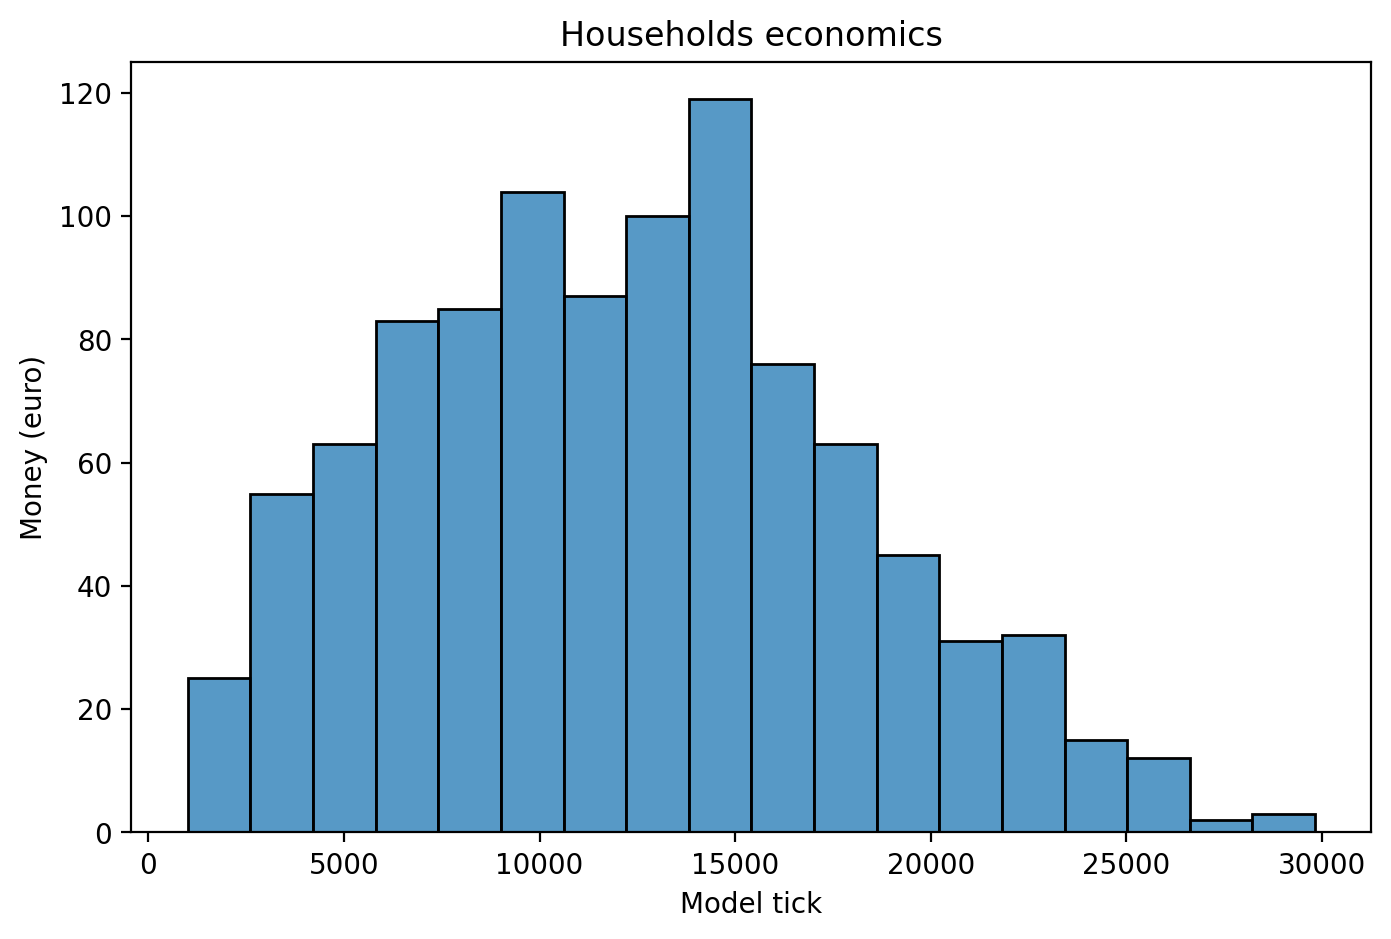

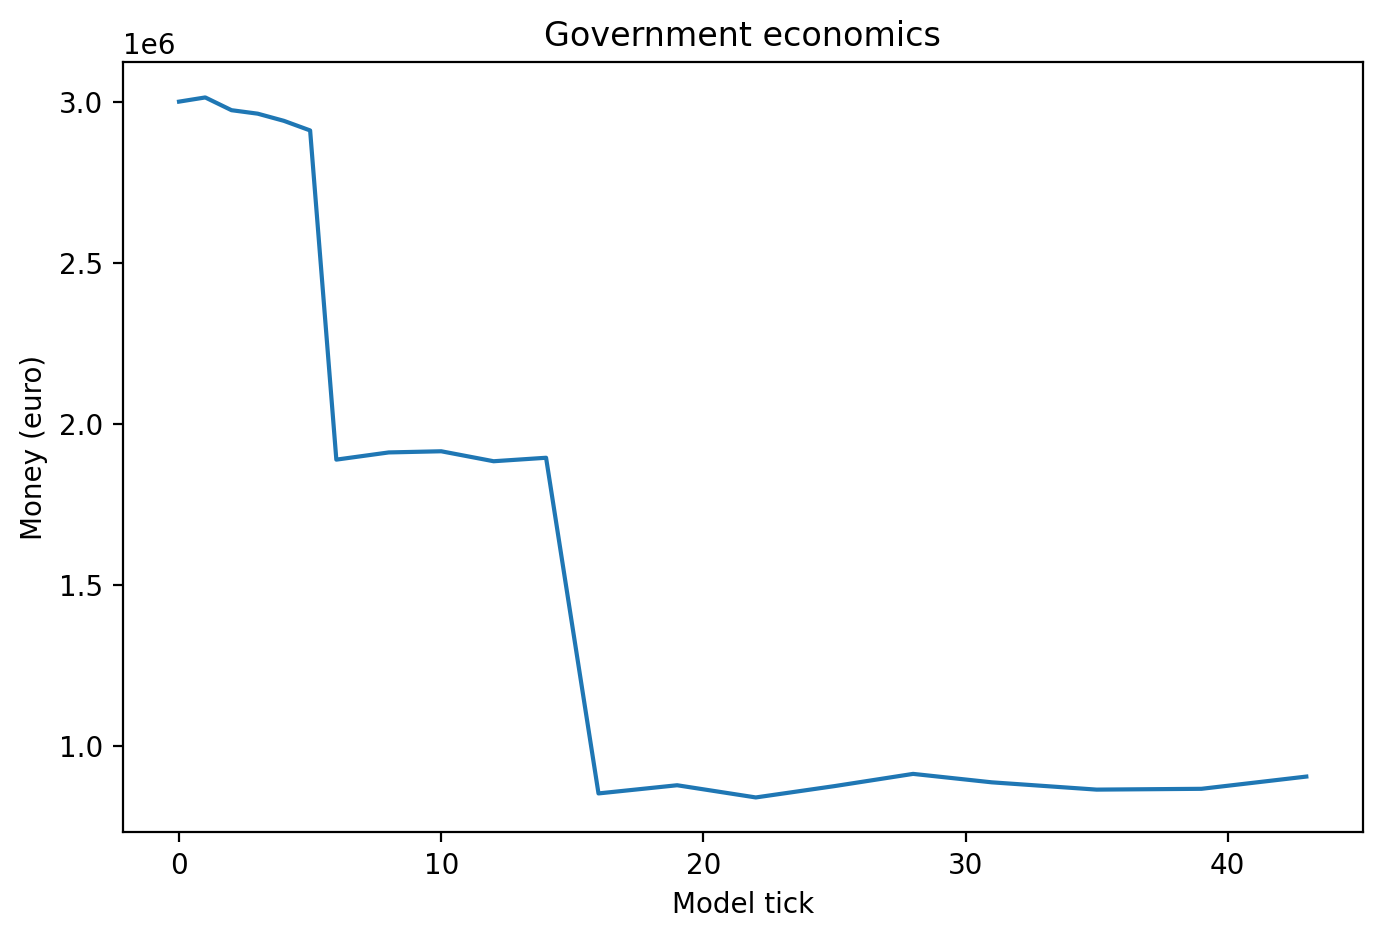

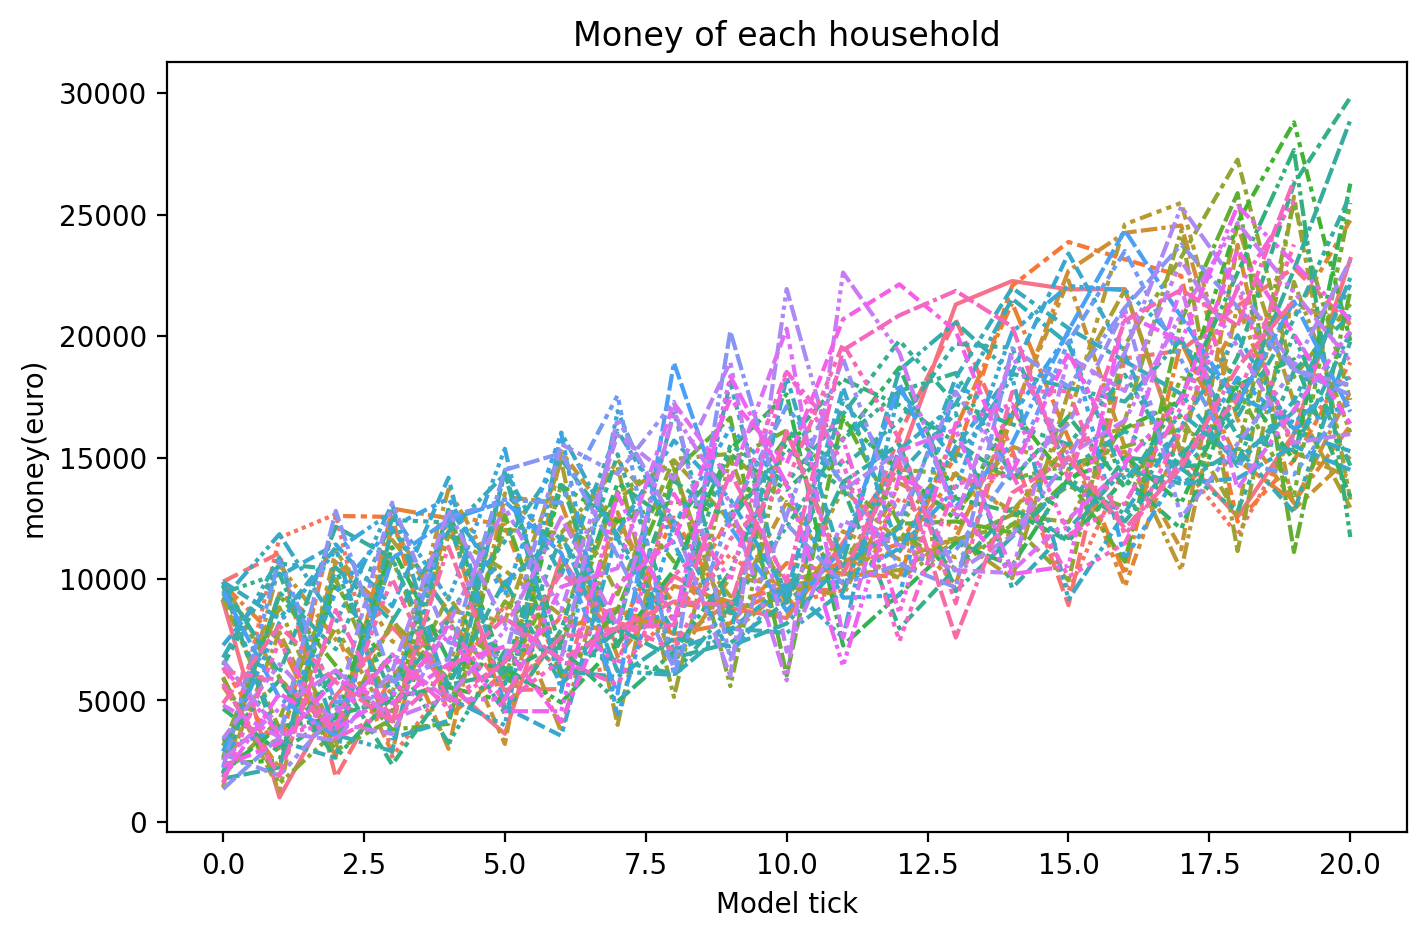

In [21]:
import seaborn as sns

#You will see that agents adapt at step 5 most because than the flood happend and only than the media will have influance on it.

fig, ax = plt.subplots(figsize=(8,5), dpi=200)
plt.title("Households economics")
ax.set_xlabel("Model tick")
ax.set_ylabel("Money (euro)")
sns.histplot(data = household_data.Money )

#You will see that agents adapt at step 5 most because than the flood happend and only than the media will have influance on it.

fig, ax = plt.subplots(figsize=(8,5), dpi=200)
plt.title("Government economics")
ax.set_xlabel("Model tick")
ax.set_ylabel("Money (euro)")
sns.lineplot(data = government_data.Money.to_list() )

#You will see that agents adapt at step 5 most because than the flood happend and only than the media will have influance on it.

fig, ax = plt.subplots(figsize=(8,5), dpi=200)
plt.title("Money of each household")
ax.set_xlabel("Model tick")
ax.set_ylabel("money(euro)")
sns.lineplot(data = household_data_per_agent, legend=None)

<Axes: title={'center': 'Policy changes over time'}, xlabel='Model tick', ylabel='Policy'>

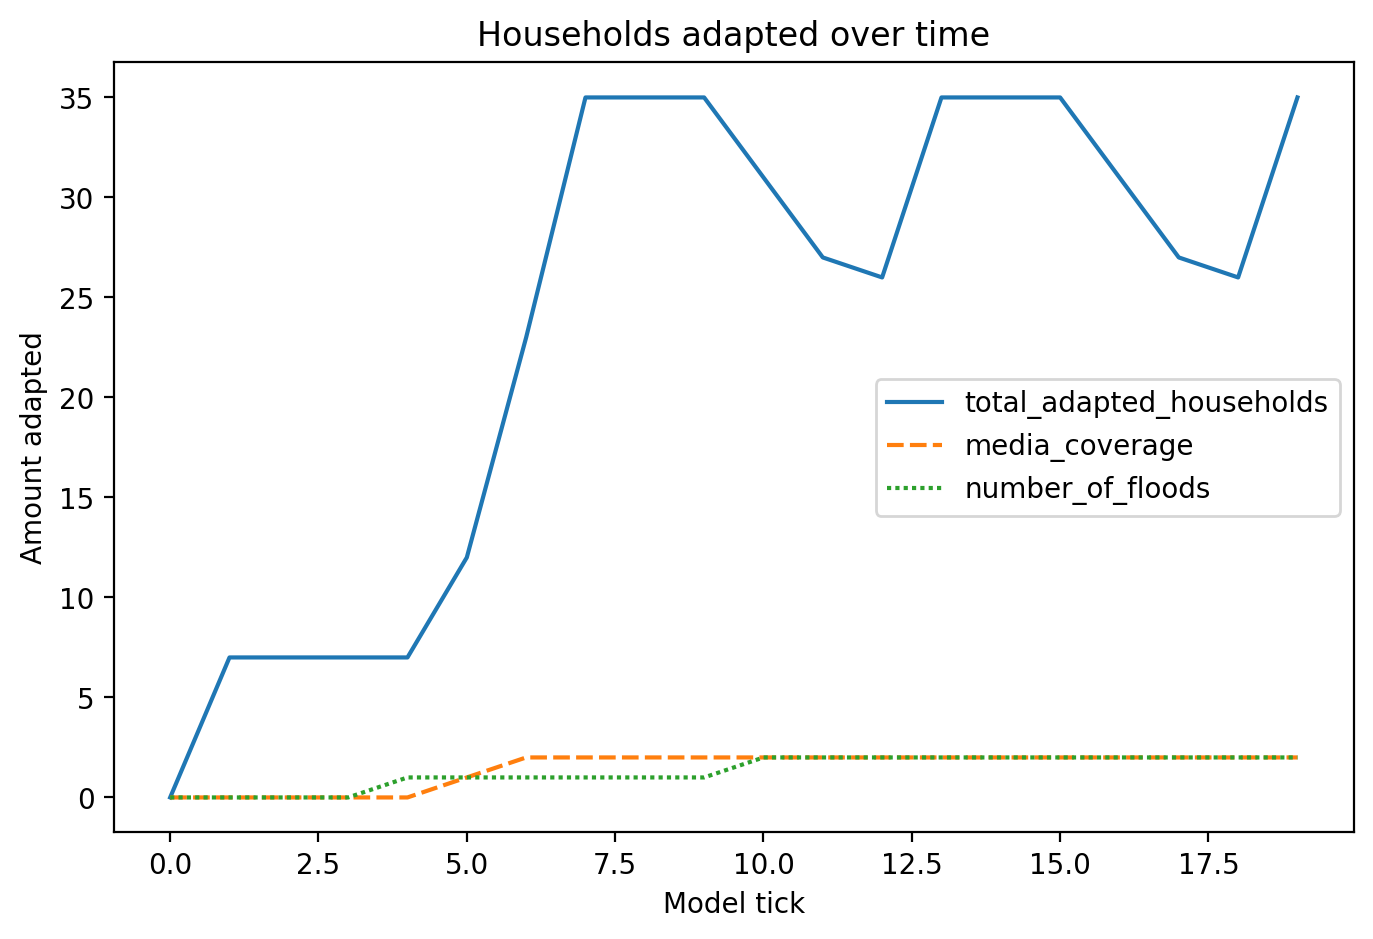

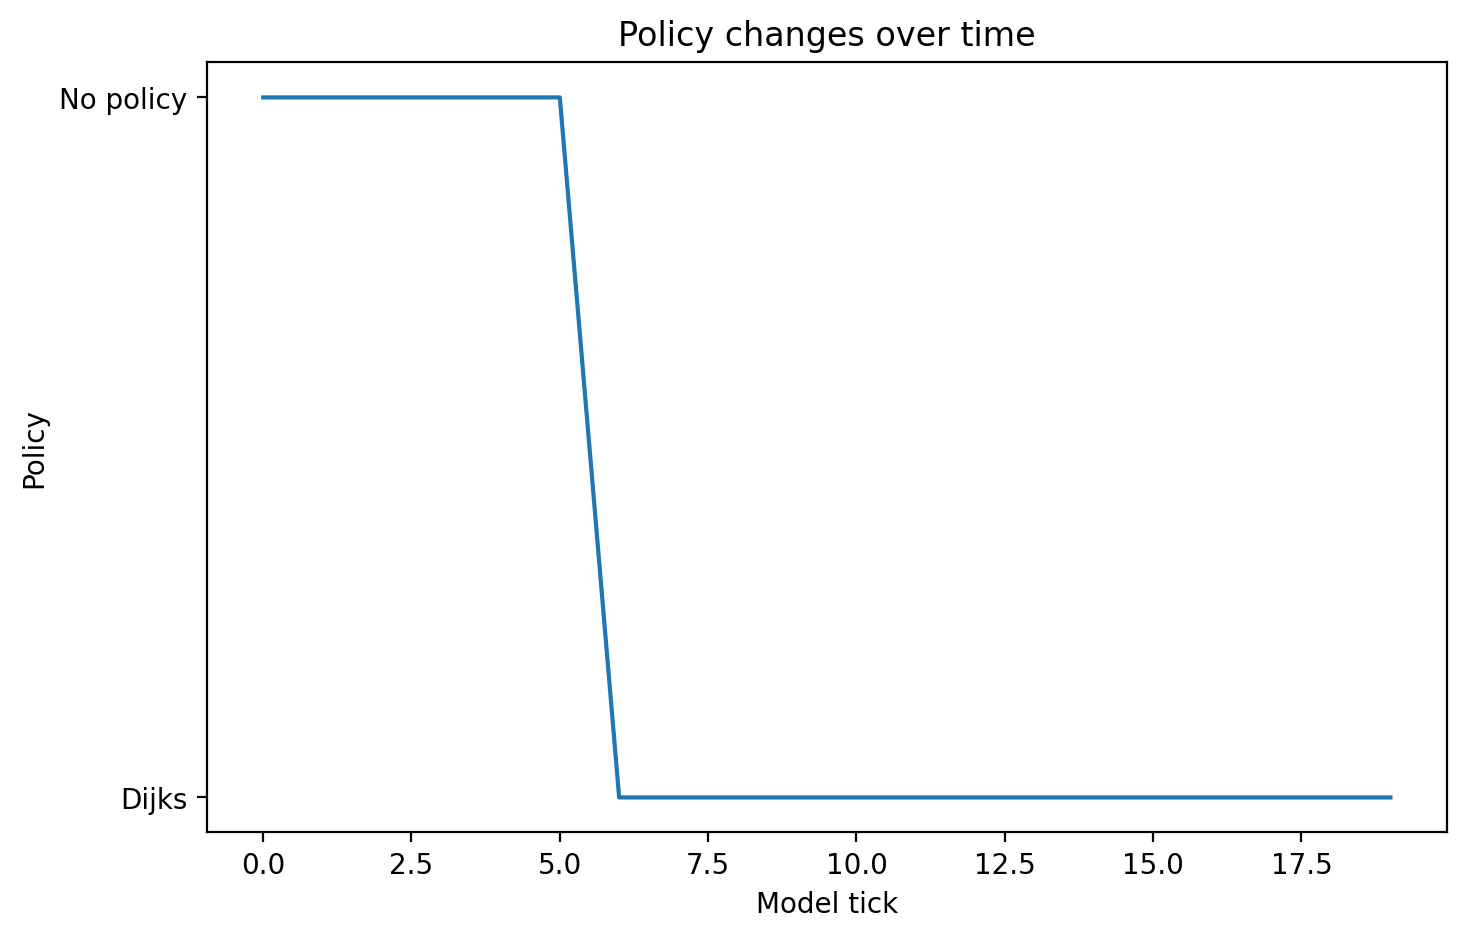

In [22]:
import seaborn as sns

#You will see that agents adapt at step 5 most because than the flood happend and only than the media will have influance on it.

fig, ax = plt.subplots(figsize=(8,5), dpi=200)
plt.title("Households adapted over time")
ax.set_xlabel("Model tick")
ax.set_ylabel("Amount adapted")
sns.lineplot(data = model_data )

fig, ax = plt.subplots(figsize=(8,5), dpi=200)
plt.title("Policy changes over time")
ax.set_xlabel("Model tick")
ax.set_ylabel("Policy")
sns.lineplot(data = model_data.current_policy )
#sns.histplot(data = model_data.current_policy)

In [9]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import matplotlib.pyplot as plt
from functions import map_domain_gdf, floodplain_gdf

In [10]:
model = AdaptationModel(number_of_households=50, flood_map_choice="harvey", network="watts_strogatz", adaptation_threshold=0.2) #reset the model

0.16458002149368597
0.16458002149368597
0.20458002149368595
0.20458002149368595


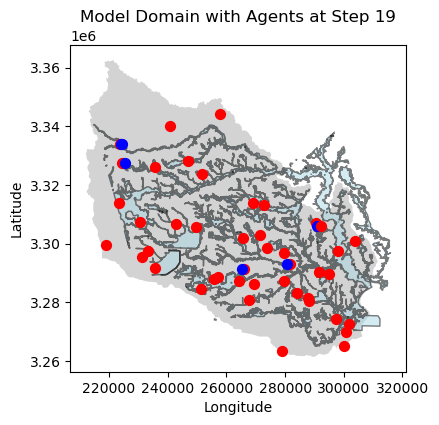

In [11]:
fig, ax = plt.subplots()

# Adjust layout to make room for annotations
fig.subplots_adjust(bottom=0.2)

# Function to plot the grid at each step
def plot_grid(model):
    ax.clear()
    
    # Plot the model domain
    map_domain_gdf.plot(ax=ax, color='lightgrey')
    #Plot the floodplain
    floodplain_gdf.plot(ax=ax, color='lightblue', edgecolor='k', alpha=0.5)

    for agent in model.schedule.agents:
        if agent.type == "household" and agent.is_adapted == False:
            #get position on the map
            ax.scatter(agent.location.x, agent.location.y, color='red', s=50)  # Bigger, hollow circle
        elif agent.type == 'household':
            ax.scatter(agent.location.x, agent.location.y, color='blue', s=50)  # Smaller, filled circle
    # Labels and title
        
    plt.title(f'Model Domain with Agents at Step {model.schedule.steps}')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

# Update function for the animation
def update(frame):
    plot_grid(model)
    model.step()
    

# Create the animation
anim = FuncAnimation(fig, update, frames=model.number_of_steps-2, repeat=False, interval=200)

# Show the animation
HTML(anim.to_jshtml())